In [1]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
from src.towers.query import QueryTower
from src.towers.candidate import CandidateTower
from src.rankings.pointwise import PointwiseRanking

from src.utils.utilities import (
    dataframe_to_Dataset,
    train_test_split,
    plot_history,
)

2024-08-28 19:19:21.995995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 19:19:22.017160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 19:19:22.024135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 19:19:22.040783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 19:19:23.144792: W tensorflow/compiler/tf2

In [3]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_recommenders as tfrs

RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8')

In [4]:
# Ratings
ratings_df = pd.read_parquet('data/100k-ratings.parquet')
ratings_columns = [
    'bucketized_user_age',
    # 'movie_genres',
    'movie_id',
    'movie_title',
    'raw_user_age',
    'timestamp',
    'user_gender',
    'user_id',
    'user_occupation_label',
    'user_occupation_text',
    'user_rating',
    'user_zip_code'
]
ratings_dataset = dataframe_to_Dataset(ratings_df, ratings_columns)

I0000 00:00:1724860165.247401  278150 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724860165.276232  278150 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724860165.276315  278150 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724860165.280541  278150 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724860165.280637  278150 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
# Ratings
movies_df = pd.read_parquet('data/100k-movies.parquet')
movies_columns = [
    # 'movie_genres',
    'movie_id',
    'movie_title'
]
movies_dataset = dataframe_to_Dataset(movies_df, movies_columns)

In [6]:
# Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp'],
        # Target Variable
        'score': rating['user_rating']
    }
)

In [7]:
# Train and validation splits
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = 0.0001,
    random_state = RANDOM_STATE,
    buffer_size = tf.data.UNKNOWN_CARDINALITY
)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 10
validset_size: 99990


In [8]:
candidate_tower = CandidateTower(
    dataset = ratings_trainset,
    embedding_dim = 4
)

query_tower = QueryTower(
    dataset = ratings_trainset,
    embedding_dim = 4
)

[INFO - 2024-08-28 19:19:30]	`MovieEmbeddingModel.__create_id_embedding_layer()` executed in 3.5 seconds.
[INFO - 2024-08-28 19:19:34]	`MovieEmbeddingModel.__create_title_embedding_layer()` executed in 3.6 seconds.
[INFO - 2024-08-28 19:19:37]	`UserEmbeddingModel.__create_id_embedding_layer()` executed in 3.7 seconds.


In [9]:
# Ranking
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError()
    ]
)
ranking_model = PointwiseRanking(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    task = ranking_task
)

In [10]:
ranking_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
ranking_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3
)

# Ranking
optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.1)
ranking_model.compile(optimizer = optimizer)
history = ranking_model.fit(
    ranking_ratings_trainset,
    validation_data = ranking_ratings_validset,
    validation_freq = 1,
    epochs = 100,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/100


I0000 00:00:1724860183.334697  278274 service.cc:146] XLA service 0x7fe1fac2bde0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724860183.334796  278274 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-28 19:19:43.339777: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 19:19:43.351572: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1724860183.416480  278274 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 10s 10s/step - root_mean_squared_error: 0.0000e+00 - loss: 16.1192 - regularization_loss: 0.0000e+00 - total_loss: 16.1192 - val_root_mean_squared_error: 3.0125 - val_loss: 9.0218 - val_regularization_loss: 0.0000e+00 - val_total_loss: 9.0218
Epoch 2/100
1/1 [==============================] - 1s 728ms/step - root_mean_squared_error: 0.0000e+00 - loss: 10.8330 - regularization_loss: 0.0000e+00 - total_loss: 10.8330 - val_root_mean_squared_error: 1.3105 - val_loss: 1.6819 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.6819
Epoch 3/100
1/1 [==============================] - 1s 739ms/step - root_mean_squared_error: 0.0000e+00 - loss: 1.0132 - regularization_loss: 0.0000e+00 - total_loss: 1.0132 - val_root_mean_squared_error: 1.8968 - val_loss: 3.5500 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.5500
Epoch 4/100
1/1 [==============================] - 1s 666ms/step - root_mean_squared_error: 0.0000e+00 - loss: 4.2471 - regulariza

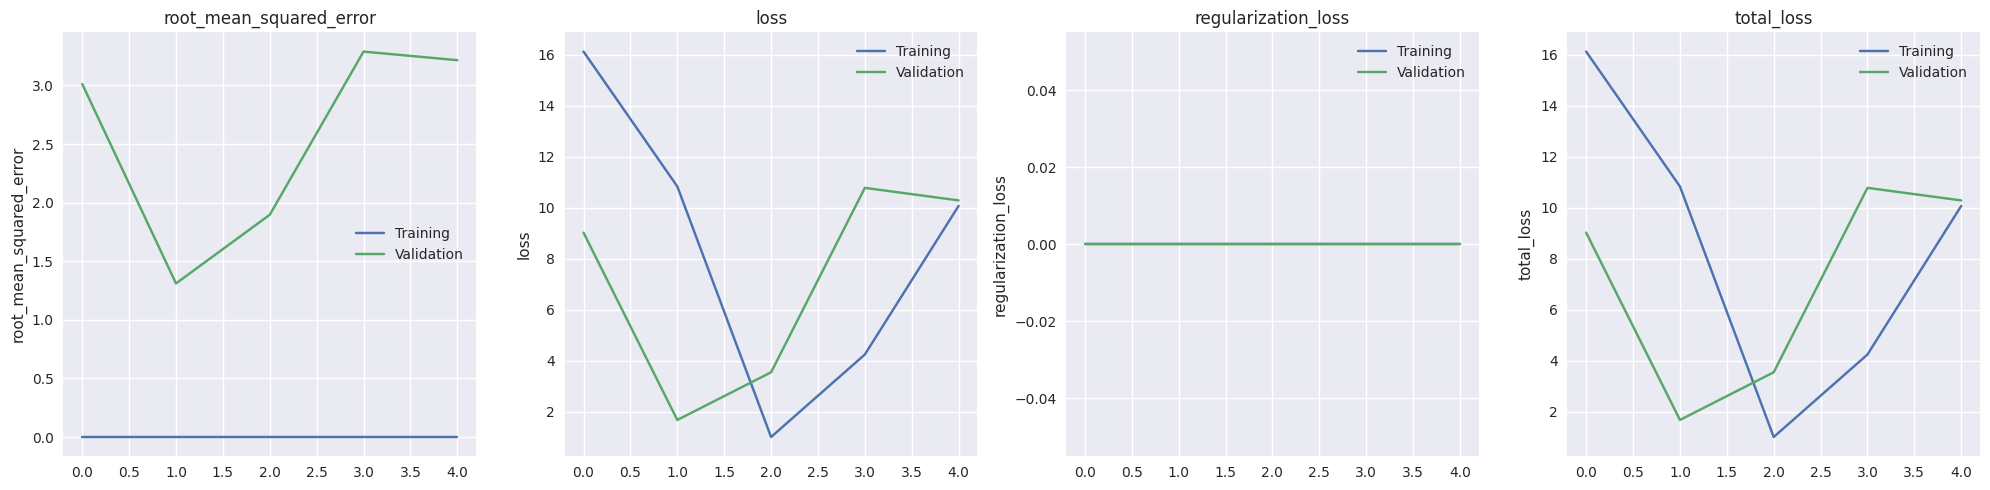

In [11]:
plot_history(history = history)

In [12]:
movie_ids = ['1681', '1457', '500', '838', 'xxx']
for movie_id in movie_ids:
  pred = ranking_model({
      "user_id": tf.convert_to_tensor(["1"]),
      "movie_id": tf.convert_to_tensor([movie_id]),
      "movie_title": tf.convert_to_tensor(["God Father"])
  })
  print(f"Prediction for movie_id {movie_id}: {pred}")

Prediction for movie_id 1681: [[0.5263679]]
Prediction for movie_id 1457: [[0.5263679]]
Prediction for movie_id 500: [[0.5263679]]
Prediction for movie_id 838: [[0.5263679]]
Prediction for movie_id xxx: [[0.5263679]]
